Imports

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

Mean Variance

Fetch Stock Download Data

In [5]:
stocks = [
    "AAPL", "GOOGL", "MSFT", "TSLA", "AMZN",  # Tech
    "JPM", "BAC", "GS",  # Banking
    "XOM", "CVX",  # Energy
    "JNJ", "PFE",  # Healthcare
    "WMT", "TGT",  # Retail
    "NVDA", "AMD",  # Semiconductors
    "DIS", "NFLX",   # Entertainment
    "ACN","ADBE","GOOG"
]



data = yf.download(stocks, start="2020-01-01", end="2025-03-01")
data = data["Close"]
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  21 of 21 completed

Ticker           AAPL         ACN        ADBE        AMD       AMZN  \
Date                                                                  
2020-01-02  72.716057  195.263611  334.429993  49.099998  94.900497   
2020-01-03  72.009109  194.938385  331.809998  48.599998  93.748497   
2020-01-06  72.582916  193.665451  333.709991  48.389999  95.143997   
2020-01-07  72.241554  189.484207  333.390015  48.250000  95.343002   
2020-01-08  73.403648  189.855850  337.869995  47.830002  94.598503   

Ticker            BAC        CVX         DIS       GOOG      GOOGL  ...  \
Date                                                                ...   
2020-01-02  31.275539  96.158699  146.391525  68.046204  68.108368  ...   
2020-01-03  30.626162  95.826118  144.712280  67.712280  67.752075  ...   
2020-01-06  30.582281  95.501450  143.872650  69.381882  69.557945  ...   
2020-01-07  30.380451  94.281929  143.922028  69.338577  69.423584  ...   
2020-01-08  30.687586  93.204971  143.625702  69.885

In [6]:
fundamentals = {}

for stock in stocks:
    ticker = yf.Ticker(stock)

    # Fetch fundamental metrics
    pe_ratio = ticker.info.get("trailingPE", None)  # P/E Ratio

    # Use Operating Income
    operating_income = ticker.financials.loc["Operating Income"].sum() if "Operating Income" in ticker.financials.index else None

    # Use Research and Development (R&D)
    r_and_d = ticker.financials.loc["Research And Development"].sum() if "Research And Development" in ticker.financials.index else None

    profit_margin = ticker.info.get("profitMargins", None)  # Profit Margin


    fundamentals[stock] = {
        "P/E": pe_ratio,
        "Operating Income": operating_income,
        "R&D": r_and_d,
        "Profit Margin": profit_margin
    }

fundamentals_df = pd.DataFrame(fundamentals).T
print(fundamentals_df)

              P/E  Operating Income           R&D  Profit Margin
AAPL    34.587300      4.659030e+11  1.094500e+11        0.24295
GOOGL   19.195274      3.502390e+11  1.658150e+11        0.28604
MSFT    30.499193      3.512550e+11  1.019330e+11        0.35428
TSLA   129.827580      3.697900e+10  1.417700e+10        0.07259
AMZN    34.849907      1.425720e+11  4.274000e+10        0.09287
JPM     12.302432               NaN           NaN        0.35060
BAC     12.850467               NaN           NaN        0.28243
GS      13.403751               NaN           NaN        0.27368
XOM     15.016582      1.721600e+11           NaN        0.09889
CVX     17.087448      1.012760e+11           NaN        0.09031
JNJ     28.225863      8.751400e+10  6.072900e+10        0.15836
PFE     17.879433      8.117500e+10  4.328900e+10        0.12622
WMT     35.331950      1.027300e+11           NaN        0.02854
TGT     11.698647      2.406700e+10           NaN        0.03839
NVDA    37.302720      1.

Count number of Stocks in the portfolio

In [7]:
num_stocks = len(data.columns)
num_stocks

21

Setup some Constants

In [8]:
weights = np.ones(num_stocks) / num_stocks
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252


Makes the Covariance Matirx

In [9]:
# Fill missing values with median to prevent errors
fundamentals_df.fillna(fundamentals_df.median(), inplace=True)

# Normalize the fundamental metrics (scale between 0 and 1)
scaler = MinMaxScaler()
normalized_fundamentals = scaler.fit_transform(fundamentals_df)

# Define fundamental-based risk model
# Higher P/E increases risk, higher Operating Income and Profit Margins lower risk
fundamental_risk = (1 / (normalized_fundamentals[:, 0] + 0.01)) - (normalized_fundamentals[:, 1]) - (normalized_fundamentals[:, 3]) + (normalized_fundamentals[:, 2] * 0.5)

# Convert to a diagonal covariance matrix
fundamental_cov_matrix = np.diag(fundamental_risk)

Mean Variance Analysis

In [10]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)  # Expected return
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Risk (volatility)
    return portfolio_return, portfolio_risk

def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

In [11]:
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds: No short-selling (weights must be between 0 and 1)
bounds = [(0, 1) for _ in range(num_stocks)]

# Optimization process
optimized = minimize(minimize_volatility, weights, args=(mean_returns, fundamental_cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal portfolio weights
optimal_weights = optimized.x

Returns Portfolio Optimization Precents

In [12]:
for stock, weight in zip(stocks, optimal_weights):
    print(f"{stock}: {weight:.2%}")

AAPL: 5.77%
GOOGL: 1.72%
MSFT: 4.56%
TSLA: 25.85%
AMZN: 4.85%
JPM: 0.34%
BAC: 0.44%
GS: 0.55%
XOM: 0.85%
CVX: 1.25%
JNJ: 3.44%
PFE: 1.39%
WMT: 4.74%
TGT: 0.22%
NVDA: 6.84%
AMD: 17.79%
DIS: 4.00%
NFLX: 7.87%
ACN: 2.76%
ADBE: 3.02%
GOOG: 1.77%


LSTM Solution

In [13]:
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2025-01-01")[["Close"]].dropna()
df.columns = ["price"]

[*********************100%***********************]  1 of 1 completed


In [14]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append((seq, label))
    return sequences

# Normalize prices
window_size = 30
scaled = (df['price'] - df['price'].mean()) / df['price'].std()
data = scaled.values.astype(np.float32)

# Create input/output sequences
sequences = create_sequences(data, window_size)
X = torch.tensor([s[0] for s in sequences]).unsqueeze(-1)  # [samples, window_size, 1]
y = torch.tensor([s[1] for s in sequences]).unsqueeze(-1)  # [samples, 1]

C:\Users\Dylan\AppData\Local\Temp\ipykernel_28932\351167698.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X = torch.tensor([s[0] for s in sequences]).unsqueeze(-1)  # [samples, window_size, 1]


In [15]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])  # last timestep
        return out

Train the Model

In [16]:
model = LSTMForecast()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    output = model(X)
    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.9951
Epoch 10, Loss: 0.7303
Epoch 20, Loss: 0.0426
Epoch 30, Loss: 0.0339
Epoch 40, Loss: 0.0383
Epoch 50, Loss: 0.0276
Epoch 60, Loss: 0.0182
Epoch 70, Loss: 0.0132
Epoch 80, Loss: 0.0095
Epoch 90, Loss: 0.0068


Forecast Next Day's Price

In [17]:
model.eval()
last_sequence = X[-1].unsqueeze(0)  # shape: [1, 30, 1]
predicted_scaled = model(last_sequence).item()

# Convert back to actual price
predicted_price = predicted_scaled * df['price'].std() + df['price'].mean()
current_price = df['price'].iloc[-1]

print(f"Predicted next-day price for {ticker}: ${predicted_price:.2f}")
print(f"Current price: ${current_price:.2f}")
expected_return = (predicted_price - current_price) / current_price
print(f"Expected return: {expected_return:.2%}")


Predicted next-day price for AAPL: $241.99
Current price: $250.14
Expected return: -3.26%


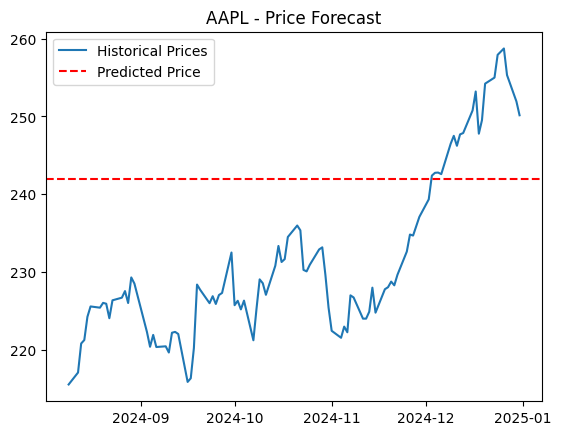

In [18]:
plt.plot(df.index[-100:], df['price'][-100:], label="Historical Prices")
plt.axhline(predicted_price, color='red', linestyle='--', label='Predicted Price')
plt.legend()
plt.title(f"{ticker} - Price Forecast")
plt.show()